# console : mlflow ui
# Accès console MLFlow : http://127.0.0.1:5000
# 1 - Chargement & configuration - 18 sec

In [1]:
import sys
import os
sys.path.append('../src')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from requirements import *
from src import data_preprocessing as dp
from src import model_training as mt
from src import evaluate as ev
from src import utils

import mlflow
mlflow.set_experiment("Sentiment Analysis Project")

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




✅ Toutes les librairies sont présentes et prêtes à être utilisées !



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/906586012259731436', creation_time=1742576058928, experiment_id='906586012259731436', last_update_time=1742576058928, lifecycle_stage='active', name='Sentiment Analysis Project', tags={}>

## 1.1 - Démarrage automatique du serveur MLflow (Backend SQLite + Artifact Store local)

In [2]:
utils.start_mlflow_server(port = 5000)
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Sentiment Analysis Project")

🚀 Démarrage du serveur MLflow (SQLite backend)...
✅ MLflow UI disponible sur : http://127.0.0.1:5000


2025/03/23 16:07:45 INFO mlflow.tracking.fluent: Experiment with name 'Sentiment Analysis Project' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/1', creation_time=1742742465185, experiment_id='1', last_update_time=1742742465185, lifecycle_stage='active', name='Sentiment Analysis Project', tags={}>

## 1.2 - Affichage de la structure dossier

In [29]:
utils.afficher_structure_dossier("..", max_niveaux = 1)

├── .git
├── ├── COMMIT_EDITMSG
├── ├── FETCH_HEAD
├── ├── HEAD
├── ├── config
├── ├── description
├── ├── hooks
├── ├── index
├── ├── info
├── ├── logs
├── ├── objects
├── └── refs
├── .gitattributes
├── .gitignore
├── README.md
├── data
├── └── tweets.csv
├── env_p7_MLOps
├── ├── Include
├── ├── Lib
├── ├── Scripts
├── ├── etc
├── ├── pyvenv.cfg
├── └── share
├── logs
├── ├── events.out.tfevents.1741361244.PC-ARNAUD.37024.0
├── ├── events.out.tfevents.1741362034.PC-ARNAUD.9628.0
├── ├── events.out.tfevents.1741364804.PC-ARNAUD.38328.0
├── ├── events.out.tfevents.1741507476.PC-ARNAUD.3024.0
├── ├── events.out.tfevents.1741507646.PC-ARNAUD.3024.1
├── ├── events.out.tfevents.1741513667.PC-ARNAUD.13340.0
├── ├── events.out.tfevents.1741599815.PC-ARNAUD.27736.0
├── ├── events.out.tfevents.1741603247.PC-ARNAUD.3852.0
├── ├── events.out.tfevents.1741603852.PC-ARNAUD.24400.0
├── ├── events.out.tfevents.1741604981.PC-ARNAUD.29024.0
├── ├── events.out.tfevents.1741609885.PC-ARNAUD.30608.0
├── 

## 1.3 - Chargement des données

In [4]:
print(f"📂 Répertoire courant : {os.getcwd()}")

📂 Répertoire courant : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\notebooks


In [5]:
data_path = "../data/tweets.csv"
if os.path.exists(data_path):
    tweets = pd.read_csv(data_path, encoding = "ISO-8859-1")
    print("✅ Dataset chargé avec succès !")
else:
    print("❌ Le fichier tweets.csv est introuvable.")

✅ Dataset chargé avec succès !


# 2 - Exploration & nettoyage
## 2.1 - Nettoyage initial

In [6]:
print(tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [7]:
# Renommage des colonnes
tweets.columns = ["label", "id", "date", "query", "user", "text"]

In [8]:
# Suppression des colonnes inutiles
tweets = tweets.drop(columns=["id", "date", "query", "user"])

In [9]:
# Conversion des labels (0 et 4 → 0 et 1)
tweets['label'] = tweets['label'].map({0: 0, 4: 1})

## 2.2 - Suppression des doublons sur la colonne "text"

In [10]:
before = len(tweets)
tweets = tweets.drop_duplicates(subset = ["text"], keep = "first").reset_index(drop = True)
after = len(tweets)
print(f"✅ Suppression des doublons effectuée : {before - after} doublons supprimés.")
tweets = tweets.reset_index(drop = True)

✅ Suppression des doublons effectuée : 18534 doublons supprimés.


## 2.3 - Nettoyage avancé

In [11]:
tweets_cleaned = dp.preprocess_tweets_parallel(tweets)

✅ Chargement des tweets nettoyés depuis ../models_saved/cleaned_tweets.pkl


# 3 - Vader scoring

In [12]:
vader_scores = dp.compute_vader_scores(tweets_cleaned)

2025/03/23 16:07:48 INFO mlflow.tracking.fluent: Experiment with name 'P7_sentiment_analysis' does not exist. Creating a new experiment.


🚀 Nouveau run démarré : b8ce549e48754177b68429f931b8ccad
✅ Scores VADER chargés depuis ../models_saved/vader_scores.pkl...

📊 Rapport de classification VADER :
              precision    recall  f1-score   support

           0       0.81      0.43      0.56    790184
           1       0.61      0.90      0.73    791281

    accuracy                           0.67   1581465
   macro avg       0.71      0.67      0.65   1581465
weighted avg       0.71      0.67      0.65   1581465

🏃 View run funny-squid-356 at: http://127.0.0.1:5000/#/experiments/2/runs/b8ce549e48754177b68429f931b8ccad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 4 - Vectorisation des tweets

In [13]:
sample_size = 15000  # Taille échantillon USE (modifiable)

tweets_sampled = tweets_cleaned.sample(n = sample_size, random_state = 70).reset_index(drop = True)

X_bow, X_tfidf, X_fasttext, X_use, y_use = dp.vectorize_and_save(
    tweets_cleaned['text'], tweets_sampled['text'],
    tweets_cleaned['label'], tweets_sampled['label']
)

🚀 Nouveau run démarré : 94fbfe5501964a6dbe98476ae681eb40
📂 Chargement des matrices vectorisées existantes...
🏃 View run rambunctious-cub-375 at: http://127.0.0.1:5000/#/experiments/2/runs/94fbfe5501964a6dbe98476ae681eb40
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 5 - Modélisation Classique (TF-IDF + Régression Logistique) - 2 min 08

In [ ]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
    X_tfidf, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify=tweets_cleaned['label']
)
log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train)
# log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : 75fa370913e04d5daba4da11f4e802fa
🔄 Entraînement Régression Logistique...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Modèle sauvegardé sous ../models_saved/log_reg_model.pkl


2025/03/23 16:10:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sentiment_model_logreg'.
2025/03/23 16:10:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_logreg, version 1
Created version '1' of model 'sentiment_model_logreg'.


🏃 View run big-snipe-539 at: http://127.0.0.1:5000/#/experiments/2/runs/75fa370913e04d5daba4da11f4e802fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : 8945e8c0eaf84b58bab0267cb2d4764c

⏱️ [Régression Logistique] - Fin : 131.23 sec | CPU: 33.8% | RAM: 45.2%
🏃 View run handsome-hog-756 at: http://127.0.0.1:5000/#/experiments/2/runs/8945e8c0eaf84b58bab0267cb2d4764c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


# 6 - Modèles Avancés (Random Forest / LightGBM / LSTM)
## 6.1 - FastText + Random Forest - 4 min 51

In [15]:
X_ft_train, X_ft_test, y_train, y_test = train_test_split(
    X_fasttext, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify = tweets_cleaned['label']
)
# rf_model = mt.train_random_forest(X_ft_train, y_train)
rf_model = mt.train_random_forest(X_ft_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : 19f259f8b0374b68a617af58a59a0f5c
✅ Modèle RandomForest sauvegardé sous ../models_saved/rf_model.pkl


2025/03/23 16:15:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sentiment_model_rf'.
2025/03/23 16:15:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_rf, version 1
Created version '1' of model 'sentiment_model_rf'.


🏃 View run spiffy-trout-287 at: http://127.0.0.1:5000/#/experiments/2/runs/19f259f8b0374b68a617af58a59a0f5c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : c9e79457228c4cbb9648231567208781

⏱️ [RandomForest] - Fin : 293.51 sec | CPU: 25.6% | RAM: 42.1%
🏃 View run victorious-deer-435 at: http://127.0.0.1:5000/#/experiments/2/runs/c9e79457228c4cbb9648231567208781
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


## 6.2 - FastText + LSTM - 7 min 44

In [ ]:
lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'])
# lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'], force_retrain = True)

🚀 Nouveau run démarré : cb6658326fb0409cb6d0f11b2f4ce70e


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Entraînement LSTM...


Epoch 1/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.7490 - loss: 0.5125 - val_accuracy: 0.7578 - val_loss: 0.4943
Epoch 2/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.7603 - loss: 0.4918 - val_accuracy: 0.7627 - val_loss: 0.4873
Epoch 3/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7646 - loss: 0.4853 - val_accuracy: 0.7668 - val_loss: 0.4803
Epoch 4/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.7674 - loss: 0.4804 - val_accuracy: 0.7688 - val_loss: 0.4766
Epoch 5/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.7692 - loss: 0.4771 - val_accuracy: 0.7696 - val_loss: 0.4753
Epoch 6/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.7706 - loss: 0.4747 - val_accuracy: 0.7720 - val_loss: 0.4716
Epoch 7/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.7725 - loss: 0.4718 - val_accuracy: 0.7732 - val_loss: 0.4699
Epoch 8/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.7739 - loss:

✅ Modèle LSTM sauvegardé sous ../models_saved/lstm_model.h5

2025/03/23 16:22:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


2025/03/23 16:22:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sentiment_model_lstm'.
2025/03/23 16:22:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_lstm, version 1
Created version '1' of model 'sentiment_model_lstm'.


🏃 View run ambitious-stork-3 at: http://127.0.0.1:5000/#/experiments/2/runs/cb6658326fb0409cb6d0f11b2f4ce70e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : d4a6a9f1080341c7ba4ddf8d020004f3

⏱️ [LSTM] - Fin : 461.46 sec | CPU: 23.8% | RAM: 47.1%
🏃 View run unique-asp-896 at: http://127.0.0.1:5000/#/experiments/2/runs/d4a6a9f1080341c7ba4ddf8d020004f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


## 6.3 - USE + LightGBM

In [ ]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(
    X_use, y_use, test_size = 0.2, random_state = 70, stratify = y_use
)
lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test)
# lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test, force_retrain = True)

🚀 Nouveau run démarré : ba17c2acf2784d7aa195001132ba0e2e
🚀 Entraînement LightGBM...
Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.597038
[20]	valid_0's binary_logloss: 0.572921
[30]	valid_0's binary_logloss: 0.565325
[40]	valid_0's binary_logloss: 0.559
[50]	valid_0's binary_logloss: 0.556823
[60]	valid_0's binary_logloss: 0.555709
[70]	valid_0's binary_logloss: 0.555127
[80]	valid_0's binary_logloss: 0.557184
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.555127
✅ Modèle LightGBM sauvegardé sous ../models_saved/lgbm_model.txt


2025/03/23 16:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sentiment_model_lgbm'.
2025/03/23 16:22:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_model_lgbm, version 1
Created version '1' of model 'sentiment_model_lgbm'.


🏃 View run burly-crow-593 at: http://127.0.0.1:5000/#/experiments/2/runs/ba17c2acf2784d7aa195001132ba0e2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🚀 Nouveau run démarré : 335dec8adfd94fb5a63e1a48ef71c8f7

⏱️ [LightGBM] - Fin : 5.77 sec | CPU: 35.9% | RAM: 44.5%
🏃 View run sincere-hare-737 at: http://127.0.0.1:5000/#/experiments/2/runs/335dec8adfd94fb5a63e1a48ef71c8f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
✅ Run terminé.


## 6.4 - DistilBERT
### 6.4.1 - Préparation

In [18]:
df_sample = dp.prepare_distilbert_dataset(tweets_cleaned)
tokenized = dp.tokenize_distilbert_dataset(df_sample)

🚀 Nouveau run démarré : 16431b20a2c5477daaa96004e26e70d7
✅ Dataset DistilBERT existant. Chargement...
🏃 View run enchanting-deer-924 at: http://127.0.0.1:5000/#/experiments/2/runs/16431b20a2c5477daaa96004e26e70d7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
🚀 Nouveau run démarré : 3fa46bb9637e4327a3b3f9b755e5608a
✅ Tokenized dataset déjà existant. Chargement depuis ../models_saved/tokenized_distilbert_dataset...
🏃 View run adaptable-lamb-757 at: http://127.0.0.1:5000/#/experiments/2/runs/3fa46bb9637e4327a3b3f9b755e5608a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


### 6.2.2 - Fine-tuning 

In [19]:
model, trainer, _ = mt.train_distilbert_model(tokenized)
# model, trainer, _ = mt.train_distilbert_model(tokenized, force_retrain = True)

🚀 Nouveau run démarré : f656ce68ee634ac9b315c0363143ee7e
✅ Modèle DistilBERT déjà fine-tuné. Chargement depuis ../models_saved/distilbert_model...
🏃 View run sincere-mink-193 at: http://127.0.0.1:5000/#/experiments/2/runs/f656ce68ee634ac9b315c0363143ee7e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 7 - Evaluation

In [20]:
distilbert_acc, distilbert_f1 = ev.evaluate_distilbert_model(model, tokenized)

🚀 Nouveau run démarré : 4c296ce5234743d5a0dddb8a4b0a0063
✅ Résultats d'évaluation déjà disponibles. Chargement...

📊 Rapport DistilBERT :
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     10038
           1       0.84      0.85      0.84      9962

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

🏃 View run angry-smelt-799 at: http://127.0.0.1:5000/#/experiments/2/runs/4c296ce5234743d5a0dddb8a4b0a0063
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 8 - Comparaison finale des modèles

In [21]:
models_dict = {
    'logreg': log_reg_model,
    'rf': rf_model,
    'lstm': lstm_model,
    'lgbm': lgbm_model,
    'distilbert_metrics': {
        'accuracy': distilbert_acc,
        'f1': distilbert_f1
    }
}

datasets_dict = {
    'tfidf': {'X_test': X_tfidf_test, 'y_test': y_test},
    'fasttext': {'X_test': X_ft_test, 'y_test': y_test},
    'lstm': (X_ft_test_reshaped, y_ft_test),
    'use': {'X_test': X_use_test, 'y_test': y_use_test}
}

🚀 Nouveau run démarré : a8b3148b22cd461f89be53607030a171

📊 Résultats pour : logreg
              precision    recall  f1-score   support

           0       0.77      0.72      0.75    158037
           1       0.74      0.79      0.76    158256

    accuracy                           0.76    316293
   macro avg       0.76      0.76      0.76    316293
weighted avg       0.76      0.76      0.76    316293



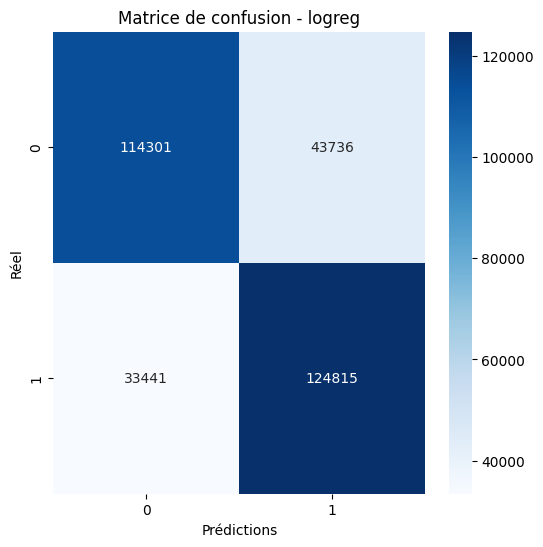


📊 Résultats pour : rf
              precision    recall  f1-score   support

           0       0.73      0.75      0.74    158037
           1       0.74      0.72      0.73    158256

    accuracy                           0.73    316293
   macro avg       0.73      0.73      0.73    316293
weighted avg       0.73      0.73      0.73    316293



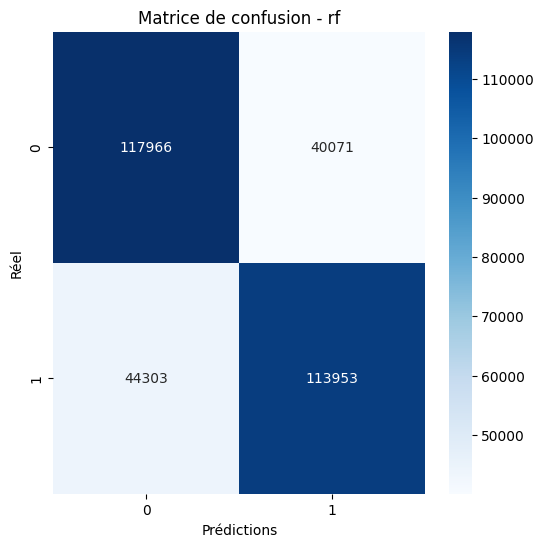

9885/9885 ━━━━━━━━━━━━━━━━━━━━ 8s 744us/step

📊 Résultats pour : lstm
              precision    recall  f1-score   support

           0       0.77      0.78      0.78    158037
           1       0.78      0.77      0.77    158256

    accuracy                           0.78    316293
   macro avg       0.78      0.78      0.78    316293
weighted avg       0.78      0.78      0.78    316293



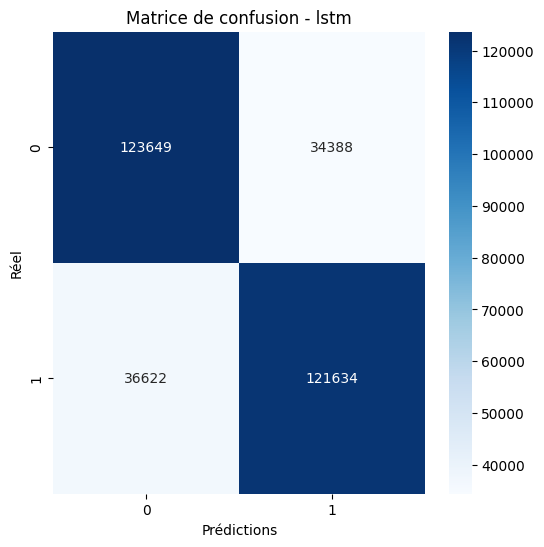


📊 Résultats pour : lgbm
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1505
           1       0.71      0.72      0.72      1495

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



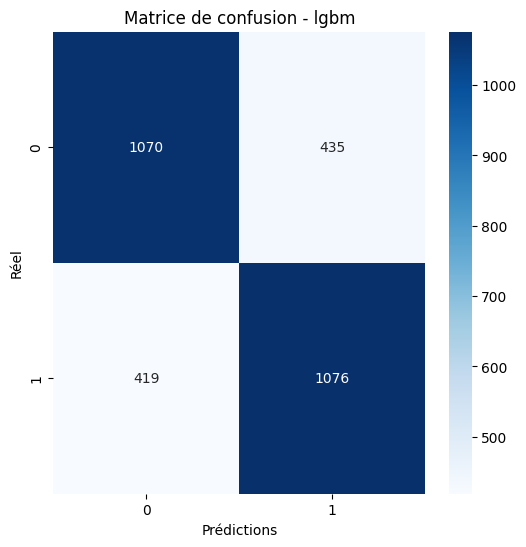


📊 Comparaison finale des modèles :


,Modèle,Accuracy,F1-score
0,logreg,0.7560,0.7638
1,rf,0.7332,0.7298
2,lstm,0.7755,0.7741
3,lgbm,0.7153,0.7159
4,DistilBERT fine-tuné,0.8423,0.8427


🏃 View run painted-sheep-817 at: http://127.0.0.1:5000/#/experiments/2/runs/a8b3148b22cd461f89be53607030a171
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


In [22]:
df_results = ev.get_all_model_scores(models_dict, datasets_dict)

# 9 - Tracking MLFlow

In [23]:
y_pred = log_reg_model.predict(X_tfidf_test)
with mlflow.start_run(run_name="Logistic Regression final metrics"):
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))

🏃 View run Logistic Regression final metrics at: http://127.0.0.1:5000/#/experiments/2/runs/0fdb4e6119194b3d888d2089bfd3869e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [24]:
if mlflow.active_run() is not None:
    mlflow.end_run()

In [25]:
with mlflow.start_run():
    # entraînement modèle, log params & metrics
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))

🏃 View run melodic-jay-176 at: http://127.0.0.1:5000/#/experiments/2/runs/1b38793f0e1c45bf94d06dfc4564bcc5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# A désactiver en production

In [26]:
utils.launch_mlflow_ui()

🚀 MLFlow UI lancé sur http://127.0.0.1:5000


In [27]:
# mlflow.end_run()  # Pour stopper tout run en cours
